# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implement ε-Greedy and UCB

In [2]:
"""
todo
1. Exception处理
2. 英文翻译
"""
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [37]:
def index_max(input_list):
    """
    return the index of the max element in the list.
    NOTICE: Tie-breaking uniformly among value-maximising arms.
    arm 0 是第一个arm
    """
    m = max(input_list)
    if m == np.inf:
        index_list = [i for i, j in enumerate(input_list) if j==np.inf]
    else:
        # handle with float
        index_list = [i for i, j in enumerate(input_list) if (abs(j-m)<=0.000001)]
    if len(index_list) == 1:
        return index_list[0]
    else:
        return np.random.choice(index_list)

In [48]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms=narms
        self.epsilon=epsilon
        # 记录每一个arm的pull的次数和得到的reward
        self.counts = [0 for col in range(self.narms)]
        self.avg_rewards = [Q0 for col in range(self.narms)]
        
    def play(self, tround, context=None):
        """
        Play a round
        play t-1轮的
        Arguments
        =========
        tround : int
            positive integer identifying the round
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
        # exploit
        if np.random.random() > self.epsilon:
            # t-1轮中的average reward中最大的
#             print(self.avg_rewards)
            return index_max(self.avg_rewards)
        else:
        # explore
            return np.random.randint(self.narms)
        
    def update(self, arm, reward, context=None):
        """
        Updates the internal state of the MAB after a play
        更新t轮的
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        old_avg_reward = self.avg_rewards[arm]
        if n == 1:
            new_avg_reward = reward
        else:
            new_avg_reward = (old_avg_reward * (n-1) + reward)/n
        self.avg_rewards[arm] = new_avg_reward

In [55]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        self.narms = narms
        self.rho = rho
        # 记录每一个arm的次数和reward
        self.counts = [0 for col in range(self.narms)]
        self.avg_rewards = [Q0 for col in range(self.narms)]
        
    def play(self, tround, context=None):
        """
        Play a round
        t-1 round
        Arguments
        =========
        tround : int
            positive integer identifying the round
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
        # tround is used for UCB
        q_values = [0.0 for arm in range(self.narms)]
        for arm in range(self.narms):
            # todo 这里其他人怎么处理
            if self.counts[arm] == 0:
                bonus = 0
            else:
                # 看下evaluation的tround是不是第t轮而不是t-1轮的结果
                bonus = np.sqrt((self.rho*np.log(tround))/self.counts[arm])
            # 是使得当前tround下达到最大的，和update不一样，update是选完arm后的action.
            q_values[arm] = self.avg_rewards[arm] + bonus
        return index_max(q_values)
        
        
    def update(self, arm, reward, context=None):
        """
        Updates the internal state of the MAB after a play
        需要update avg_rewards和self.counts
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        old_avg_reward = self.avg_rewards[arm]
        if n == 1:
            new_avg_reward = reward
        else:
            new_avg_reward = (old_avg_reward * (n-1) + reward)/n
        self.avg_rewards[arm] = new_avg_reward

## 2. Off-Policy Evaluation

In [121]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    rewards_for_matched_round = []
    tround = 1
    length = len(rewards)
    for context_round in range(length):
        context = contexts[context_round]
        response_arm = int(arms[context_round]-1)
        response_reward = rewards[context_round]
        estimate_arm = int(mab.play(tround, context))
        if estimate_arm == response_arm:
            tround += 1
            rewards_for_matched_round.append(response_reward)
            mab.update(response_arm, response_reward, context)
        if tround > nrounds:
            break
    return rewards_for_matched_round

In [7]:
# load the data
dataset = np.loadtxt('dataset.txt', dtype=int)
arms = dataset[:,0]
rewards = dataset[:,1]
contexts = dataset[:,2:102]

In [8]:
import pandas as pd
df = pd.DataFrame(dataset)
df.groupby(1).count()

,0,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,101
1,,,,,,,,,,,,,,,,,,,,,
0,8961,8961,8961,8961,8961,8961,8961,8961,8961,8961,...,8961,8961,8961,8961,8961,8961,8961,8961,8961,8961
1,1039,1039,1039,1039,1039,1039,1039,1039,1039,1039,...,1039,1039,1039,1039,1039,1039,1039,1039,1039,1039


In [122]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.2625


In [56]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.17


## 3. Contextual Bandits

In [101]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        self.A_list = [np.identity(ndims) for col in range(self.narms)]
        self.b_list = [np.zeros((ndims, 1)) for col in range(self.narms)]

    def play(self, tround, context=None):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
        p_ta_list = []
        for arm in range(self.narms):
            context_arm = context[arm*10:(arm+1)*10]
            x_ta = np.array(context_arm).reshape(-1,1)
            theta_a = np.dot(inv(self.A_list[arm]), self.b_list[arm])
            p_ta = np.dot(theta_a.T, x_ta) + self.alpha*np.sqrt(np.linalg.multi_dot([x_ta.T, inv(self.A_list[arm]), x_ta]))
            p_ta_list.append(p_ta[0][0])
        return index_max(p_ta_list)
        
    def update(self, arm, reward, context=None):
        """
        Updates the internal state of the MAB after a play
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """
        old_A_value = np.array((self.A_list[arm]))
        old_b_value = np.array((self.b_list[arm]))
        context_arm = context[arm*10:(arm+1)*10]
        x_tat = np.array(context_arm).reshape(-1,1)    
        self.A_list[arm] = old_A_value + np.dot(x_tat, x_tat.T)
        self.b_list[arm] = old_b_value + reward * x_tat
    

In [117]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))
# linUCB不是固定的么

LinUCB average reward 0.53


## 4. Evaluation

### 4.A.

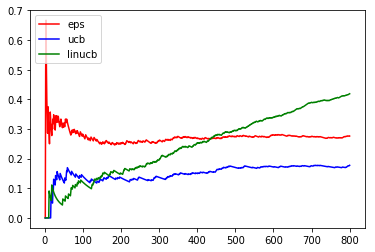

In [191]:
trials = 800
number_of_trials = np.linspace(1, trials, trials)

T = np.arange(trials)+1
mab = EpsGreedy(10, 0.05)
mab_ucb = UCB(10, 1.0)
mab_linucb = LinUCB(10, 10, 1.6)

results_eps = offlineEvaluate(mab_eps, arms, rewards, contexts, trials)
results_ucb = offlineEvaluate(mab_ucb, arms, rewards, contexts, trials)
results_linucb = offlineEvaluate(mab_linucb, arms, rewards, contexts, trials)
cum_results_epsgreedy = np.cumsum(results_eps)
cum_results_ucb = np.cumsum(results_ucb)
cum_results_linucb = np.cumsum(results_linucb)

epsgreedy_plot_result = list(map(lambda x:x[0]/x[1], zip(cum_results_epsgreedy, T)))
ucb_plot_result = list(map(lambda x:x[0]/x[1], zip(cum_results_ucb, T)))
linucb_plot_result = list(map(lambda x:x[0]/x[1], zip(cum_results_linucb, T)))

# Answer
fig = plt.figure()
ax = plt.axes()
x = np.linspace(1, trials, trials)
ax.plot(x, epsgreedy_plot_result, 'r', label='eps')
ax.plot(x, ucb_plot_result, 'b', label='ucb')
ax.plot(x, linucb_plot_result, 'g', label='linucb')
ax.legend(loc='upper left')

### 4.B.

1.5887050112577374
2.949474603520405


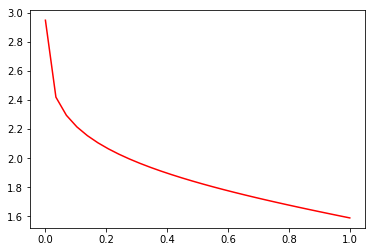

In [118]:
# 0.1, 0.01
# alpha越大，去探索的概率越大。但是说明delta越小，1-delta越大，说明置信度越高。
# alpha最小，alpha最大3
fig = plt.figure()
ax = plt.axes()
delta = np.linspace(0.001, 1, 30)
ax.plot(delta,list(map(lambda delta:(1  + np.sqrt(np.log(2/delta)/2)), delta)), 'r')
print(min(list(map(lambda delta:(1  + np.sqrt(np.log(2/delta)/2)), delta))))
print(max(list(map(lambda delta:(1  + np.sqrt(np.log(2/delta)/2)), delta))))
# A reasonable range of alpha will be 1.6 to 3

best alpha:1.6


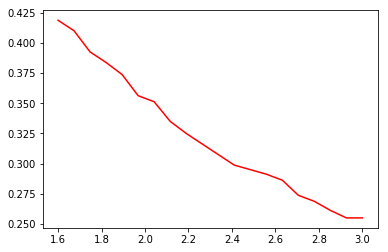

In [185]:
def grid_search(alpha_start, alpha_end):
    result_linucb_alpha = []
    for alpha in np.linspace(alpha_start, alpha_end, 20):
        result_rewards_per_alpha=[]
        mab_linucb = LinUCB(10, 10, alpha)
        result_rewards_per_alpha = offlineEvaluate(mab_linucb, arms, rewards, contexts, 800)
        result_linucb_alpha.append(np.mean(result_rewards_per_alpha))
    best_alpha = np.linspace(alpha_start, alpha_end, 20)[index_max(result_linucb_alpha)]
    return result_linucb_alpha, best_alpha

alpha_start = 1.6
alpha_end = 3
result_linucb_alpha, best_alpha = grid_search(alpha_start, alpha_end)
fig = plt.figure()
ax = plt.axes()
x = np.linspace(alpha_start, alpha_end, 20)
print('best alpha: ' + str(best_alpha))
ax.plot(x, result_linucb_alpha, 'r')
# So best alpha will be 1.6

## 5. KernelUCB

In [159]:
# Do not edit. Special import for this section.
from sklearn.metrics.pairwise import rbf_kernel

In [157]:
class KernelUCB(MAB):
    """
    Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    gamma : float
        positive real explore-exploit parameter
    
    eta : float
        positive real explore-exploit parameter
    
    kern : callable
        a kernel function from sklearn.metrics.pairwise
    """
    def __init__(self, narms, ndims, gamma, eta, kern):
        self.narms = narms
        self.ndims = ndims
        self.gamma = gamma
        self.eta = eta
        self.kern = kern
        # 这个就是ut
        self.u = list([1] + [0]*(self.narms-1))
        # 这个就是yt
        self.y = list()
        self.xt_history = list()
        self.K_t_minus1_inverse = None
        self.tround=None
    
    def play(self, tround, context):
        # 选择使得u_t-1最大的arm
        self.tround = tround
        return index_max(self.u)

    def update(self, arm, reward, context):
        # 继续做u_t的东西
        # 这个就是第10个arm
        x_t = context[arm*10:(arm+1)*10]
        self.y.append(reward)
        self.xt_history.append(x_t)
        y_t = np.array(self.y).reshape(-1,1)
        # t * 1 dimensional
        # 需要x_t, xt_history, tround
        # 注意xt_history得是tround * 1 的
        k_xt_t = np.array([kern(x_t, x_t_old) for x_t_old in self.xt_history]).reshape(-1,1)
        if self.tround == 1:
            K_t_inverse = 1/(self.kern(x_t, x_t) + self.eta)
            self.K_t_minus1_inverse = K_t_inverse
        else:
            b = np.array(list(map(lambda x,y:kern(x,y),[x_t]*self.tround, self.xt_history[:-1]))).reshape(-1,1)
            K_22 = 1/(self.kern(x_t, x_t) + self.eta - np.linalg.multi_dot([b.T, self.K_t_minus1_inverse, b]))
            K_11 = self.K_t_minus1_inverse + K_22*np.linalg.multi_dot([self.K_t_minus1_inverse, b, b.T, self.K_t_minus1_inverse])
            K_12 = (-K_22)*np.linalg.multi_dot([self.K_t_minus1_inverse, b])
            K_21 = (-K_22)*np.linalg.multi_dot([b.T, self.K_t_minus1_inverse])
            K_t_inverse = np.block([[K_11, K_12],[K_21, K_22]])
            self.K_t_minus1_inverse = K_t_inverse
        # update
        u_t = []
        for arm in range(self.narms):
            x_nt = context[arm*10:(arm+1)*10]
            k_xntt = np.array([kern(x_nt, x_t_old) for x_t_old in self.xt_history]).reshape(-1,1)
            sigma_nt = np.sqrt(self.kern(x_nt, x_nt) - np.linalg.multi_dot([k_xntt.T, K_t_inverse, k_xntt]))
            u_nt = np.linalg.multi_dot([k_xntt.T, K_t_inverse, y_t]) + self.eta/np.sqrt(self.gamma) * sigma_nt
            u_t.append(u_nt[0][0])
        self.u = u_t

In [156]:
def kern(X, Y):
    """
    RBF_kernel with gamma preset
    """
    gamma = 0.1
    X = X.reshape(1,-1)
    Y = Y.reshape(1,-1)
    return rbf_kernel(X, Y, gamma)

In [160]:
mab_kern = KernelUCB(10, 10, 0.05, 0.1, kern)
results_kern = offlineEvaluate(mab_kern, arms, rewards, contexts, 800)
print('kernel average reward', np.mean(results_kern))

kernel average reward 0.1475


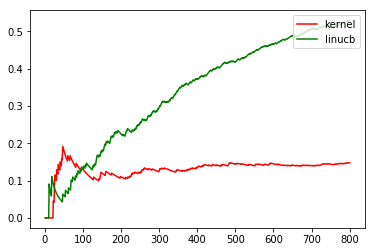

In [161]:
cum_results_kern = np.cumsum(results_kern)
kern_plot_result = list(map(lambda x:x[0]/x[1], zip(cum_results_kern, T)))

# Answer
fig = plt.figure()
ax = plt.axes()
x = np.linspace(1, 800, 800)
ax.plot(x, kern_plot_result, 'r', label='kernel')
ax.plot(x, linucb_plot_result, 'g', label='linucb')
ax.legend(loc='upper right')